In [1]:
import OpenEphys as OE
import numpy as np
import matplotlib.pyplot as plt

Loading data and separating channel of interest

In [2]:
data = OE.load('all_channels.events')
Fs = 30000;
aux = data['channel'];
a = np.where(aux == 1.0); #similar to function find in matlab, finding where there was nose poke

loading events...


Next we need to separate only the nosepoke periods higher than 50 ms

In [16]:
#### Extracting trial periods #####
timestamps = data['timestamps'];
timestamps = timestamps[a];
if ( (np.size(timestamps)%2) == 1):
    auxNP = 1;
else:
    auxNP = 0;
NPstart = timestamps[np.arange(0,np.size(timestamps)-auxNP,2)];
NPend = timestamps[np.arange(1,np.size(timestamps)-auxNP,2)];
DRRDtime = (NPend-NPstart)/Fs;
aux = np.where(DRRDtime >= .05);
DRRDtime = DRRDtime[aux];

Creating figure to analyze

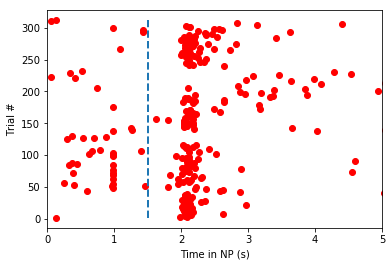

In [78]:
#figure
fig,ax = plt.subplots()
ax.set_xlim([0, 5])
ax.set_xlabel('Time in NP (s)')
ax.set_ylabel('Trial #')
x = DRRDtime;
y = np.arange(np.size(DRRDtime))+1;
plt.plot(x,y,'ro')
line1, = ax.plot(np.ones(np.size(DRRDtime))*1.5 ,y,'--', linewidth=2,label='Dashes set retroactively')
plt.show()

Now, we are going to implement Reyes method to detect change points, base on sequential t-test

In [75]:
#implementing Reyes method of change-point detection
from scipy import stats

windSize = 20;
Odds = np.zeros(np.size(DRRDtime)-windSize)
np.random.seed(12345678)
for idx in range(windSize,np.size(DRRDtime)-windSize):
    auxODD = stats.ttest_ind(DRRDtime[idx-windSize:idx],DRRDtime[idx:idx+windSize])
    Odds[idx-20] = (1 - auxODD[1])/auxODD[1]  #(1-p)/p


Plotting Odds

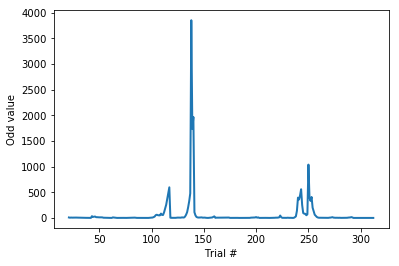

In [79]:
#
fig,ax = plt.subplots()
#ax.set_xlim([0, 5])
ax.set_xlabel('Trial #')
ax.set_ylabel('Odd value')
x = np.arange(np.size(Odds));
y = Odds;
line1, = ax.plot(x+21 ,y,'-', linewidth=2)
plt.show()

In order to select the 'true' and whether there is a change-point or not, a bootstrap need to be done. As below:

In [103]:
#bootstrap
import random as rnd

BSval = np.zeros(10000)
for ind in range(0,10000):
    auxBS = rnd.sample(DRRDtime,np.size(DRRDtime))
    
    windSize = 20;
    BSOdds = np.zeros(np.size(auxBS)-windSize)
    np.random.seed(12345678)
    for idx in range(windSize,np.size(auxBS)-windSize):
        auxODD = stats.ttest_ind(auxBS[idx-windSize:idx],auxBS[idx:idx+windSize])
        BSOdds[idx-20] = (1 - auxODD[1])/auxODD[1]  #(1-p)/p
    BSval[ind] = np.amax(BSOdds)

Observing the distribution and where the true change points stops

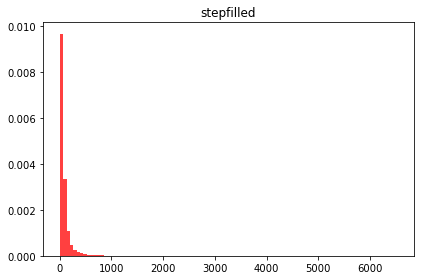

In [125]:
hist = np.histogram(BSval,40)

fig, (ax) = plt.subplots()
ax.hist(BSval,100, normed=1, histtype='stepfilled', facecolor='r', alpha=0.75)
ax.set_title('stepfilled')
fig.tight_layout()
plt.show()

In [ ]:
hist[1]